In [1]:
# pip install lifetimes

# 1： Use RFM data to predict the probability of repurchase.

In [2]:
from lifetimes.datasets import load_cdnow_summary
import pandas as pd
data = load_cdnow_summary(index_col=[0])

print(data.head())

    frequency  recency      T
ID                           
1           2    30.43  38.86
2           1     1.71  38.86
3           0     0.00  38.86
4           0     0.00  38.86
5           0     0.00  38.86


In [3]:
# Real Data
# sheet_name = 'Data' 
# usecols = ['Customer_ID','Frequency', 'Monetary','Recency', 'T']
# data = pd.read_excel('RFT Data.xlsx', sheet_name=sheet_name, usecols=usecols)

We'll use the BG/NBD model first. There are other models which we will explore in these docs, but this is the simplest to start with.

In [4]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
# penalizer_coef can be changed and optimized, 0 is default)
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'], verbose=True)
print(bgf)

Optimization terminated successfully.
         Current function value: 0.250272
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>


In [5]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.242593,0.012557,0.217981,0.267205
alpha,4.413532,0.378221,3.672218,5.154846
a,0.792886,0.185719,0.428877,1.156895
b,2.425752,0.705345,1.043276,3.808229


After fitting, we have lots of nice methods and properties attached to the fitter object, like param_ and summary.

For small samples sizes, the parameters can get implausibly large, so by adding an l2 penalty the likelihood, we can control how large these parameters can be. This is implemented as setting as positive penalizer_coef in the initialization of the model. In typical applications, penalizers on the order of 0.001 to 0.1 are effective.

Visualizing our Frequency/Recency Matrix

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

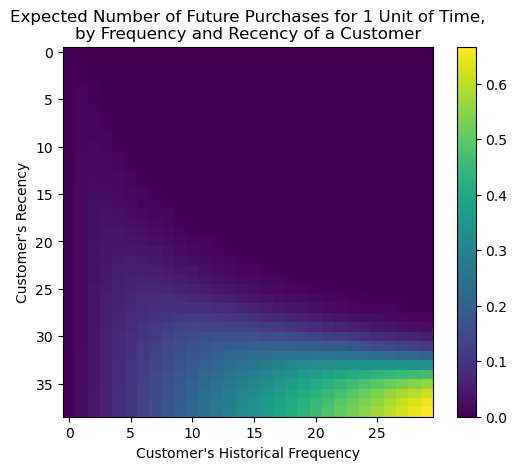

In [6]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

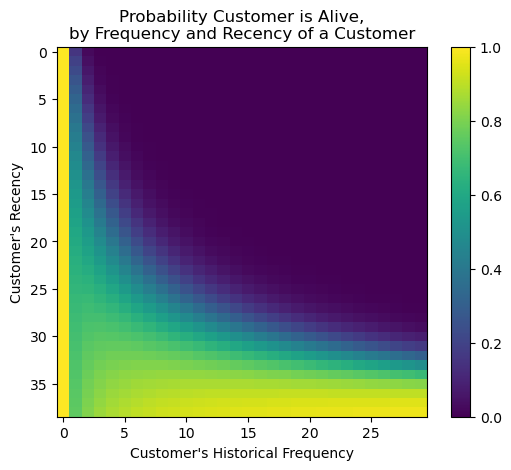

In [7]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

In [8]:
#Ranking customers from best to worst

t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,predicted_purchases
ID,,,,
509,18,35.14,35.86,0.424877
841,19,34.00,34.14,0.474738
1981,17,28.43,28.86,0.486526
157,29,37.71,38.00,0.662396
1516,26,30.86,31.00,0.710623


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

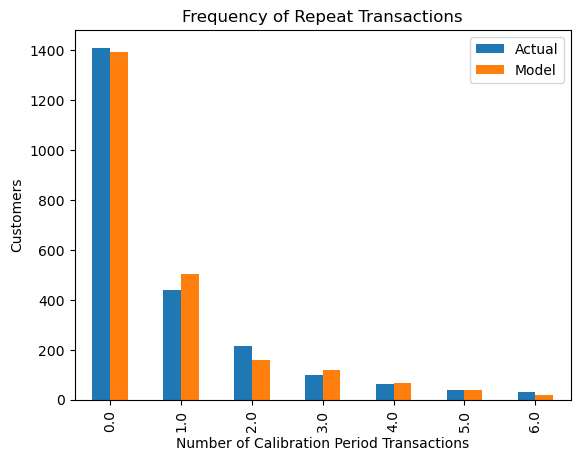

In [9]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [10]:
data

,frequency,recency,T,predicted_purchases
ID,,,,
1,2,30.43,38.86,0.037443
2,1,1.71,38.86,0.006065
3,0,0.00,38.86,0.005586
4,0,0.00,38.86,0.005586
5,0,0.00,38.86,0.005586
...,...,...,...,...
2353,0,0.00,27.00,0.007685
2354,5,24.29,27.00,0.137989
2355,0,0.00,27.00,0.007685


In [11]:
# Export results to a CSV file
data.to_csv('CLTV_RFT.csv', index=False, encoding='utf_8_sig')